### This notebook is to to evaluate the use of tensorflow to produce a regression model to predict the song release year

## Imports

In [7]:
import utils
from sklearn.preprocessing import Normalizer, QuantileTransformer
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline

# Load Dataset
Load the Million Song Dataset from 'YearPredictionsMSP.txt' (expected to be in the data folder)
Dataset Source: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

The following information is from the UCI webpage for this dataset (linked above):

Data Set Information:
You should respect the following train / test split:
train: first 463,715 examples
test: last 51,630 examples
It avoids the 'producer effect' by making sure no song
from a given artist ends up in both the train and test set.

Attribute Information:
90 attributes, 12 = timbre average, 78 = timbre covariance
The first value is the year (target), ranging from 1922 to 2011.
Features extracted from the 'timbre' features from The Echo Nest API.
We take the average and covariance over all 'segments', each segment
being described by a 12-dimensional timbre vector.

Relevant Papers:
see the website: http://millionsongdataset.com/

In [8]:
# Load the year prediction dataset from data/YearPredictionMSD.txt
train, test = utils.load_dataset("./data/YearPredictionMSD.txt", 463715)
print(f"Training set shape: {train.data.shape}")
print(f"Test set shape:     {test.data.shape}")

Training set shape: (463715, 90)
Test set shape:     (51630, 90)


## Normalization

In [9]:
norm = Normalizer(norm='l2')
norm.fit(test.data)
test.data = norm.transform(test.data)
train.data = norm.transform(train.data)

## Transform Year Labels to Uniform Distribution

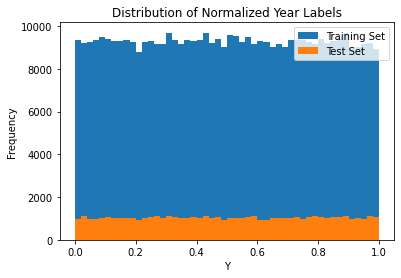

In [10]:
# Apply randomness to improve translation to uniform distribution
train_years = train.labels + 2 * np.random.rand(train.labels.shape[0]) - 1
test_years = test.labels + 2 * np.random.rand(test.labels.shape[0]) - 1

# Reshape to column arrays
train_years = np.reshape(train_years, (-1, 1))
test_years = np.reshape(test_years, (-1, 1))

# Scale year data to uniform dist from 0 to 1
y_scaler = QuantileTransformer().fit(train_years)
y_train = y_scaler.transform(train_years)
y_test = y_scaler.transform(test_years)

plt.hist(y_train, bins=50);
plt.hist(y_test, bins=50);
plt.title("Distribution of Normalized Year Labels")
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.legend(["Training Set", "Test Set"])

# Dense Neural Network (DNN) Regression Model

In [11]:
def build_and_compile_model(train: Dataset): 
    model = tf.keras.Sequential([
        layers.InputLayer(train.data.shape[1]),
        layers.Dense(90, activation='relu'), layers.Dropout(0.2),
        layers.Dense(90, activation='relu'), layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error (years)')
  plt.legend()
  plt.grid(True)
  plt.show()

In [12]:
tf.keras.backend.clear_session()
model = build_and_compile_model(train)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 90)                8190      
_________________________________________________________________
dropout (Dropout)            (None, 90)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                8190      
_________________________________________________________________
dropout_1 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 91        
Total params: 16,471
Trainable params: 16,471
Non-trainable params: 0
_________________________________________________________________
None


## Train Model

In [16]:
# Load pre-trained model from file
model = tf.keras.models.load_model("./models/dnn_regression.h5")

Epoch 1/20
2899/2899 [==============================] - 10s 3ms/step - loss: 0.2084 - val_loss: 0.2067
Epoch 2/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.2051 - val_loss: 0.2023
Epoch 3/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.2031 - val_loss: 0.2032
Epoch 4/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.2018 - val_loss: 0.2005
Epoch 5/20
2899/2899 [==============================] - 8s 3ms/step - loss: 0.2008 - val_loss: 0.1996
Epoch 6/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.2000 - val_loss: 0.1977
Epoch 7/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.1994 - val_loss: 0.1982
Epoch 8/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.1986 - val_loss: 0.1974
Epoch 9/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.1984 - val_loss: 0.1971
Epoch 10/20
2899/2899 [==============================] - 9s 3ms/step - loss: 0.19

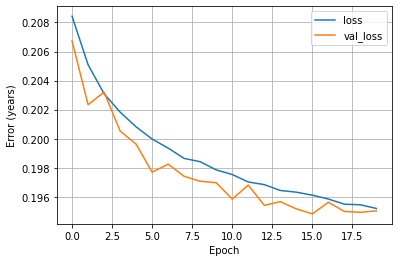

In [15]:
# Train the model and save to file
# Skip this cell if loading the model from file
history = model.fit(train.data, y_train, validation_split=0.2, epochs=20, batch_size=128)
model.save("./models/dnn_regression.h5")
plot_loss(history)

In [17]:
score = model.evaluate(train.data, y_train, verbose=0)
print("Train loss:", score)

score = model.evaluate(test.data, y_test, verbose=0)
print("Test loss:", score)

Train loss: 0.19181090593338013
Test loss: 0.20021173357963562


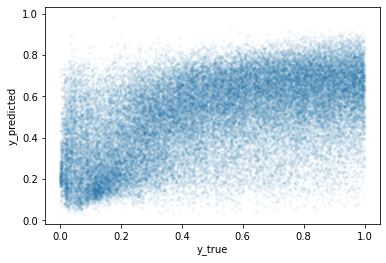

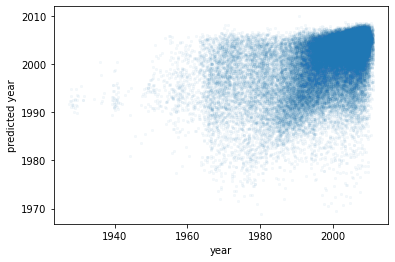

In [18]:
y_pred = model.predict(test.data)
years_pred = y_scaler.inverse_transform(y_pred)
years_true = y_scaler.inverse_transform(y_test)

plt.figure()
plt.scatter(y_test, y_pred, marker='.', linewidth=.1, alpha=0.05)
plt.xlabel('y_true')
plt.ylabel('y_predicted')
plt.show()

plt.figure()
plt.scatter(years_true, years_pred, marker='.', linewidth=.1, alpha=0.05)
plt.xlabel('year')
plt.ylabel('predicted year')
plt.show()

Text(0, 0.5, 'Probability (%)')

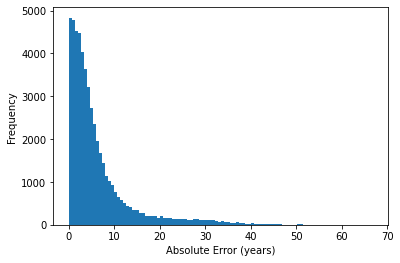

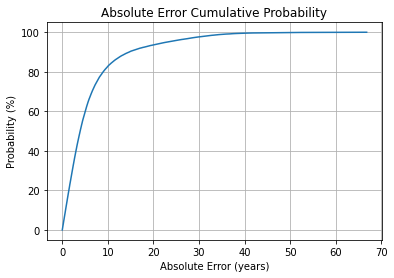

In [19]:
# Compute the errors in years and create a histogram to get a sense of
# how often the model makes good/bad predictions
abs_error = np.abs(years_true - years_pred)
abs_error = np.sort(abs_error, axis=None)

plt.figure()
plt.hist(abs_error, bins=100);
plt.xlabel('Absolute Error (years)')
plt.ylabel('Frequency')

plt.figure()
y = np.ones(abs_error.shape)
plt.plot(abs_error, 100 * np.cumsum(y) / np.sum(y))
# plt.hist(abs_error, bins=1000, density=True, cumulative=True, histtype='step');
plt.grid()
plt.title('Absolute Error Cumulative Probability')
plt.xlabel('Absolute Error (years)')
plt.ylabel('Probability (%)')


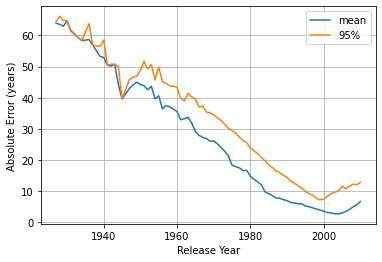

In [20]:
# Plot the mean error  by actual year
abs_error = np.abs(years_true - years_pred)

years_rounded = years_true.astype(int).flatten()
year_list = list(set(years_rounded))
error_mean = [np.mean(abs_error[y == years_rounded]) for y in year_list]
error_95p = [np.percentile(abs_error[y == years_rounded], 95) for y in year_list]

plt.plot(year_list, error_mean)
plt.plot(year_list, error_95p)
plt.grid()
plt.xlabel('Release Year')
plt.ylabel('Absolute Error (years)')
plt.legend(('mean', '95%'))